<a href="https://colab.research.google.com/github/d4rkl0rd3r3b05/AutoSuggestionTableViewController/blob/master/FashionMNIST_Classification_Practice_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 8.9 MB/s eta 0:00:00


## Import the essential packages

In [ ]:
# For basic math functions
import math
import numpy as np

# Torch essentials
import torch
from torch import nn
from torch import optim

# Torch metric
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

# Miscellaneous
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Torch Vision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T


# visualize
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

## Getting sample data from torchvision

In [ ]:
train_data = datasets.FashionMNIST("data/", train=True, transform=ToTensor(), download=True)
test_data = datasets.FashionMNIST("data/", train=False, transform=ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16565961.72it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274813.32it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5046640.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21463496.02it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Transformation to Dataloader for efficiency

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

classes = train_data.classes

## Define plot function to visulize the data

In [ ]:
from PIL import Image
import torch.nn.functional as F


def plot_image_grid(X, y, pred=None, rows=4):
  """ Function to plot a grid of images with respective titles """

  fig = plt.figure(figsize=(15,10))

  number_of_images = len(y)
  columns = math.ceil(number_of_images/rows)

  for index in range(1, number_of_images+1):
    fig.add_subplot(rows, columns, index)

    img = X[index-1]
    transformer = T.ToPILImage()
    img_scaled = transformer(img).resize((160, 160))

    label = classes[y[index-1]]
    pred_label = "" if pred is None else classes[pred[index-1]]

    plt.imshow(img_scaled, cmap='gray')

    if pred is None:
      plt.title(label, fontsize=8, c='b', wrap=True)
    else:
      if pred_label ==  label :
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='g', wrap=True)
      else:
        plt.title(f"True:{label}| Pred:{pred_label}", fontsize=8, c='r', wrap=True)


    plt.axis(False)
    fig.subplots_adjust(top=1)
    fig.tight_layout()


## Inspect and analyze the data

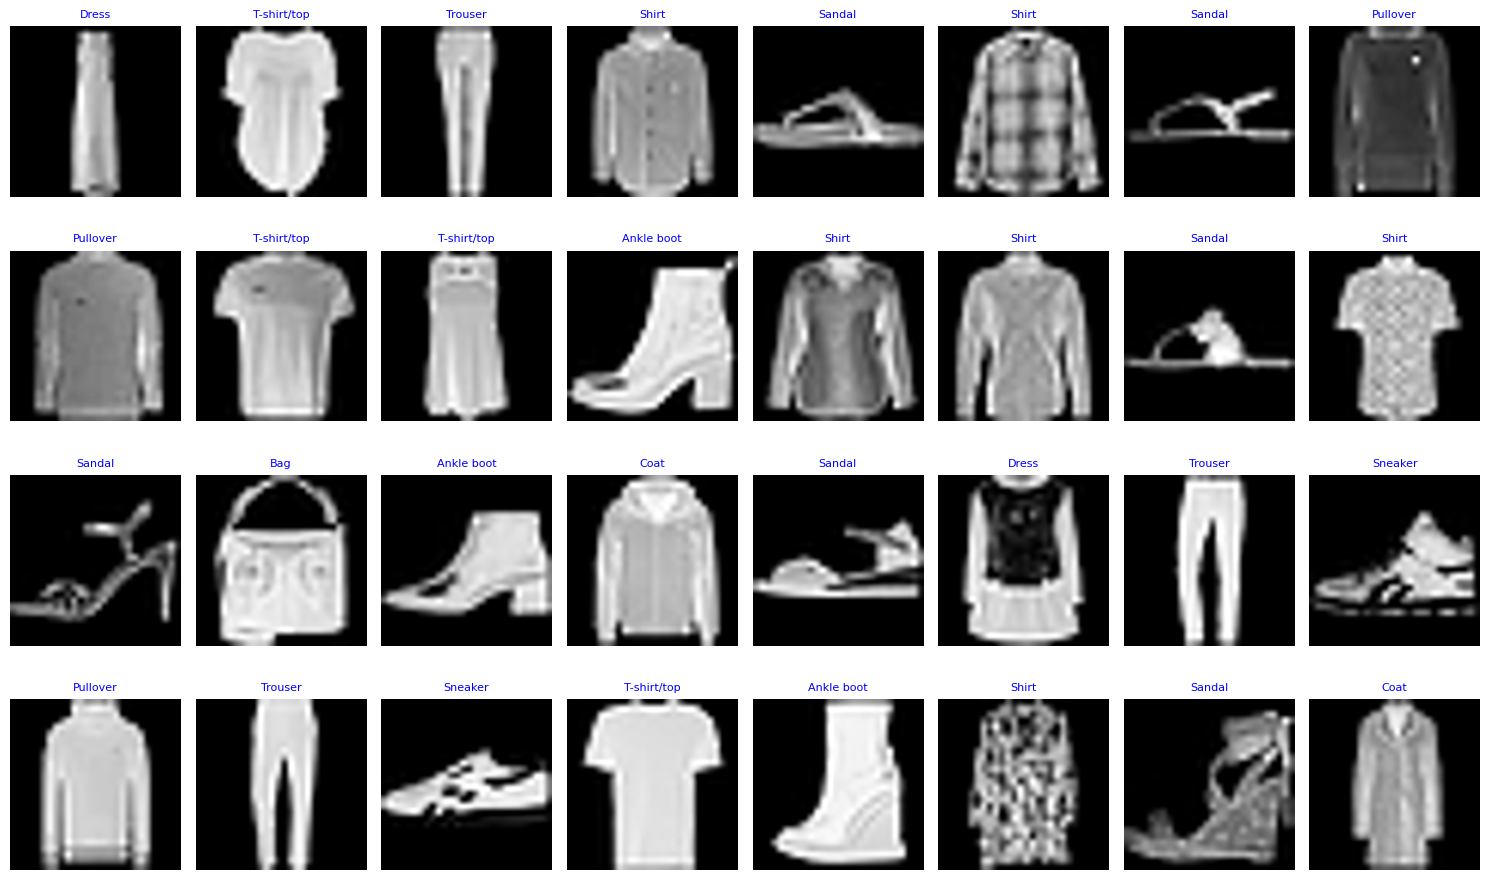

In [ ]:
X,y = next(iter(train_dataloader))
plot_image_grid(X, y)

In [ ]:
# Define classification model
class ImageClassifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_nodes=8):
    super().__init__()

    self.block_1 = nn.Sequential(nn.Conv2d(input_features, hidden_nodes, kernel_size=3,padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2,stride=2))

    self.block_2 = nn.Sequential(nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_nodes, hidden_nodes, kernel_size=3,padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2,stride=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_nodes*7*7, out_features=output_features))


  def forward(self, x: torch.tensor) -> torch.tensor:
    x = self.block_1(x)
    x = self.block_2(x)
    return self.classifier(x)


classifier = ImageClassifier(input_features=1, output_features=len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=classifier.parameters(), lr=0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(classes))

In [ ]:
# Training Loop
def train_step(model: nn.Module,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               dataloader: torch.utils.data.DataLoader):

  total_loss, total_accuracy = 0, 0
  for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
    model.train()

    pred = model(X)

    loss = criterion(pred, y)
    accuracy = accuracy_fn(pred, y)

    total_loss += loss
    total_accuracy += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"Training for Batch: {batch} | Loss: {loss} | Accuracy: {accuracy*100:.2f}")

  avg_loss = total_loss/len(dataloader)
  avg_accuracy = total_accuracy/len(dataloader)
  print(f"Training complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

  return (avg_loss, avg_accuracy)

# Testing Loop
def test_step(model: nn.Module,
              criterion: nn.Module,
              accuracy_fn,
              dataloader: torch.utils.data.DataLoader):

  model.eval()
  with torch.inference_mode():
    total_loss, total_accuracy = 0, 0
    pred_labels = []
    for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
      pred_logits = model(X)
      pred = pred_logits.argmax(dim=1)
      pred_labels.append(pred)


      loss = criterion(pred_logits, y)
      accuracy = accuracy_fn(pred_logits, y)

      total_loss += loss
      total_accuracy += accuracy

    avg_loss = total_loss/len(dataloader)
    avg_accuracy = total_accuracy/len(dataloader)
    print(f"Testing complete with Average Total Loss: {avg_loss} & Average Total Accuracy: {avg_accuracy*100:.2f}" )

    return (avg_loss, avg_accuracy, pred_labels)


In [ ]:
EPOCH = 3

start_time = timer()

total_train_loss, total_train_accuracy = 0, 0
total_test_loss, total_test_accuracy = 0, 0

for index in range(EPOCH):
  total_train_loss, total_train_accuracy = train_step(classifier,
                                                      criterion = criterion,
                                                      optimizer=optimizer,
                                                      accuracy_fn=accuracy_fn,
                                                      dataloader=train_dataloader)

  total_test_loss, total_test_accuracy, pred_labels = test_step(classifier,
                                                                criterion = criterion,
                                                                accuracy_fn=accuracy_fn,
                                                                dataloader=test_dataloader)

end_time = timer()

print(f"Modelling complete in {end_time-start_time}")
print(f"Train Results: Train Total Loss: {total_train_loss} & Train Total Accuracy: {total_train_accuracy*100:.2f}" )
print(f"Train Results: Test Total Loss: {total_test_loss} & Test Total Accuracy: {total_test_accuracy*100:.2f}" )


  0%|          | 0/1875 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 2.309882879257202 | Accuracy: 6.25
Training for Batch: 200 | Loss: 2.291590452194214 | Accuracy: 12.50
Training for Batch: 400 | Loss: 1.2145774364471436 | Accuracy: 53.12
Training for Batch: 600 | Loss: 0.9561168551445007 | Accuracy: 62.50
Training for Batch: 800 | Loss: 0.7703181505203247 | Accuracy: 65.62
Training for Batch: 1000 | Loss: 0.5530032515525818 | Accuracy: 78.12
Training for Batch: 1200 | Loss: 0.45679035782814026 | Accuracy: 78.12
Training for Batch: 1400 | Loss: 0.4340679347515106 | Accuracy: 84.38
Training for Batch: 1600 | Loss: 0.5714313983917236 | Accuracy: 75.00
Training for Batch: 1800 | Loss: 0.8306347727775574 | Accuracy: 75.00
Training complete with Average Total Loss: 1.0357733964920044 & Average Total Accuracy: 61.80


  0%|          | 0/313 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.6350383758544922 & Average Total Accuracy: 76.18


  0%|          | 0/1875 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.703649640083313 | Accuracy: 75.00
Training for Batch: 200 | Loss: 0.5121899843215942 | Accuracy: 84.38
Training for Batch: 400 | Loss: 0.6456802487373352 | Accuracy: 75.00
Training for Batch: 600 | Loss: 0.44933536648750305 | Accuracy: 81.25
Training for Batch: 800 | Loss: 0.610527753829956 | Accuracy: 75.00
Training for Batch: 1000 | Loss: 0.42656442523002625 | Accuracy: 87.50
Training for Batch: 1200 | Loss: 0.6733677387237549 | Accuracy: 71.88
Training for Batch: 1400 | Loss: 0.20533674955368042 | Accuracy: 96.88
Training for Batch: 1600 | Loss: 0.23344923555850983 | Accuracy: 96.88
Training for Batch: 1800 | Loss: 0.5009369254112244 | Accuracy: 84.38
Training complete with Average Total Loss: 0.5309979319572449 & Average Total Accuracy: 80.85


  0%|          | 0/313 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4898264706134796 & Average Total Accuracy: 82.91


  0%|          | 0/1875 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.47099873423576355 | Accuracy: 78.12
Training for Batch: 200 | Loss: 0.3485125005245209 | Accuracy: 90.62
Training for Batch: 400 | Loss: 0.43877527117729187 | Accuracy: 84.38
Training for Batch: 600 | Loss: 0.4094943702220917 | Accuracy: 81.25
Training for Batch: 800 | Loss: 0.6571184396743774 | Accuracy: 71.88
Training for Batch: 1000 | Loss: 0.4843420088291168 | Accuracy: 81.25
Training for Batch: 1200 | Loss: 0.6391634941101074 | Accuracy: 71.88
Training for Batch: 1400 | Loss: 0.5322428941726685 | Accuracy: 81.25
Training for Batch: 1600 | Loss: 0.3957003057003021 | Accuracy: 84.38
Training for Batch: 1800 | Loss: 0.48224741220474243 | Accuracy: 84.38
Training complete with Average Total Loss: 0.46381473541259766 & Average Total Accuracy: 83.54


  0%|          | 0/313 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.5047484040260315 & Average Total Accuracy: 81.08
Modelling complete in 133.72548061700002
Train Results: Train Total Loss: 0.46381473541259766 & Train Total Accuracy: 83.54
Train Results: Test Total Loss: 0.5047484040260315 & Test Total Accuracy: 81.08


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

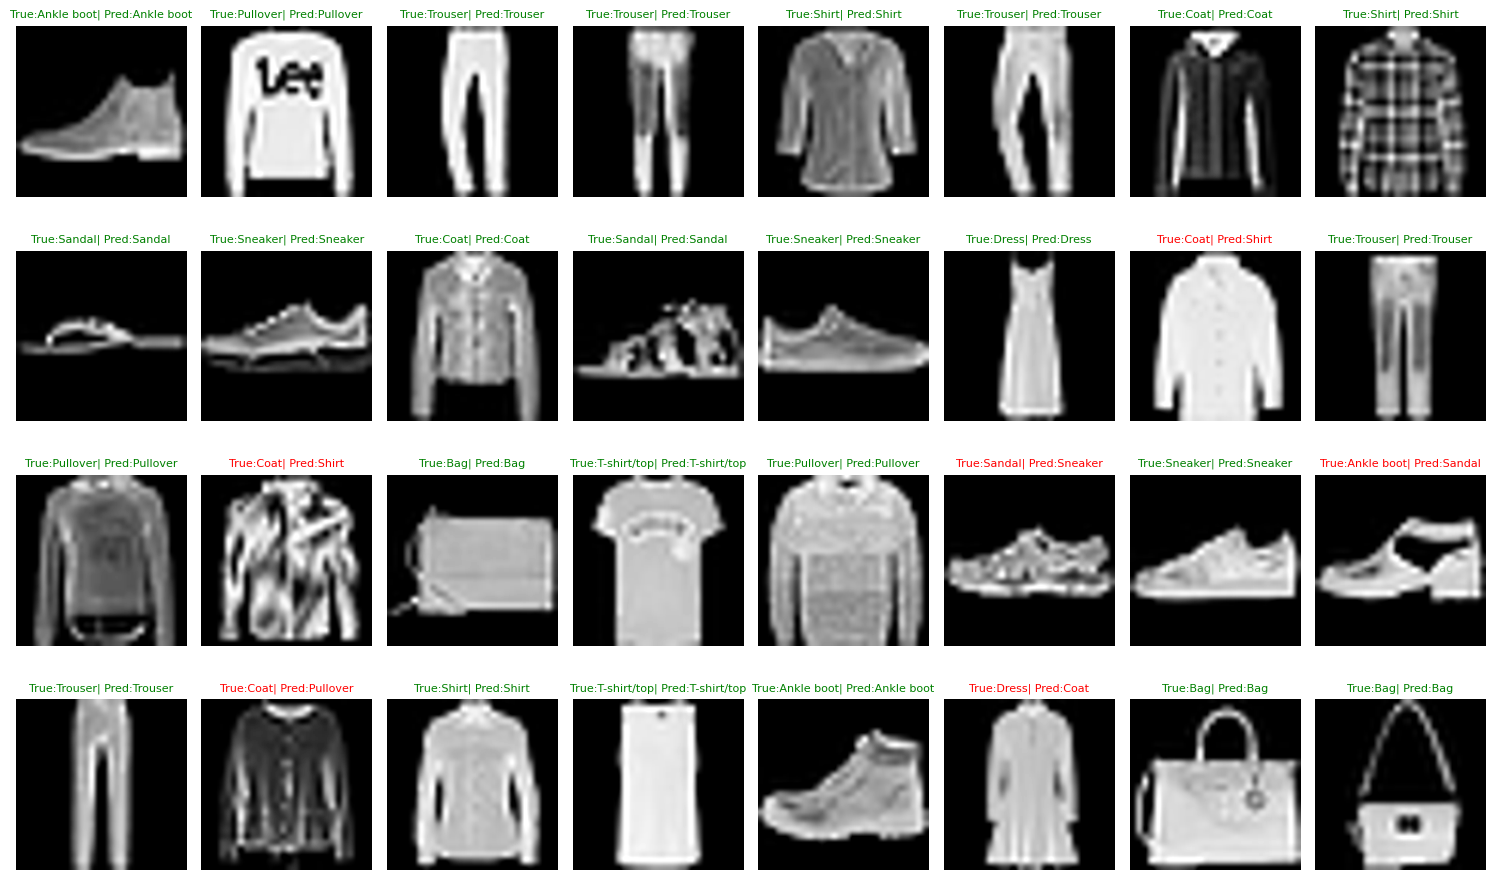

In [ ]:
classifier.eval()
with torch.inference_mode():
  index = torch.randint(len(test_dataloader),(32,))
  test_X, test_y = next(iter(test_dataloader))#test_dataloader.dataset.data[index], test_dataloader.dataset.targets[index]
  test_pred_logits = classifier(test_X)
  test_pred = test_pred_logits.argmax(dim=1)
  plot_image_grid(test_X, test_y, test_pred)

test_X.shape, test_y.shape

# Calculating and plotting confusion matrix

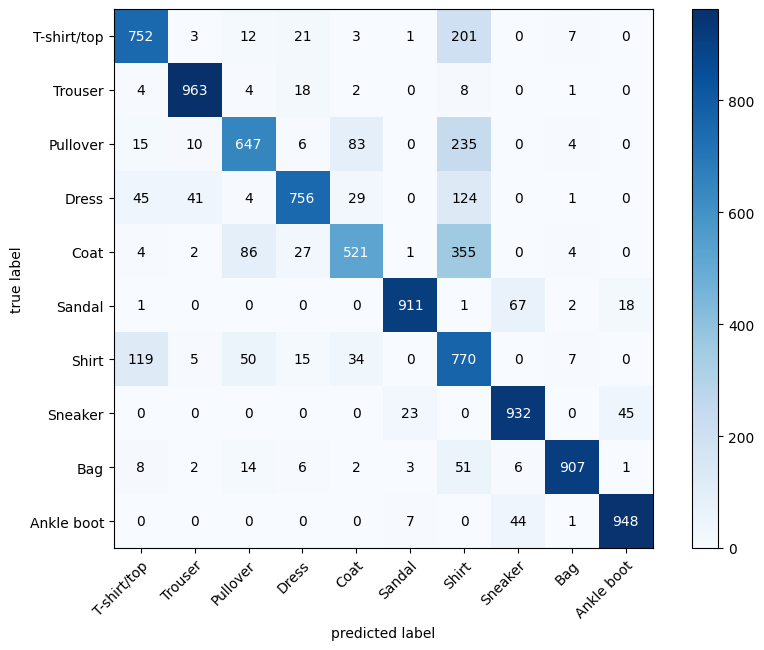

In [ ]:
conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(classes))

conf_mat_tensor = conf_mat(torch.tensor(np.hstack(pred_labels)), test_dataloader.dataset.targets).numpy()

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor,
                                colorbar=True,
                                class_names=classes,
                                figsize=(10, 7))
plt.show()

## Saving the model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "FashionMNIST_Classification_Practice_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=classifier.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/FashionMNIST_Classification_Practice_CNN.pth


## Load the saved model

In [ ]:
loaded_classifier = ImageClassifier(input_features=1, output_features=len(classes))


# Load in the saved state_dict()
loaded_classifier.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-13-0bf68668588b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_classifier.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>